## QSAR vs GCN Performance Comparison

This notebook loads the baseline QSAR summaries (classification & regression) and the GCN final metrics, then produces side-by-side bar charts and radar plots for both tasks.


In [1]:
# Step 1: Mount Drive & Imports
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Baseline QSAR classifier → model: 'SVM', input: 'genetic_algorithm', accuracy: 0.828
Final GCN → accuracy: 0.698, precision: 0.678, recall: 0.698, f1_score: 0.686


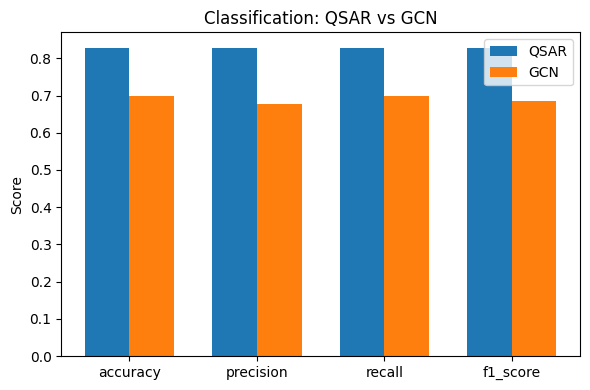

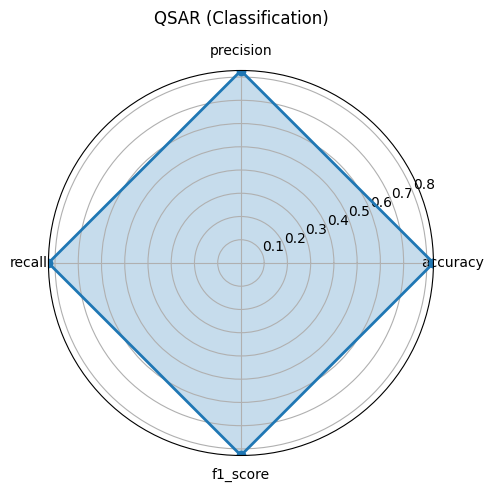

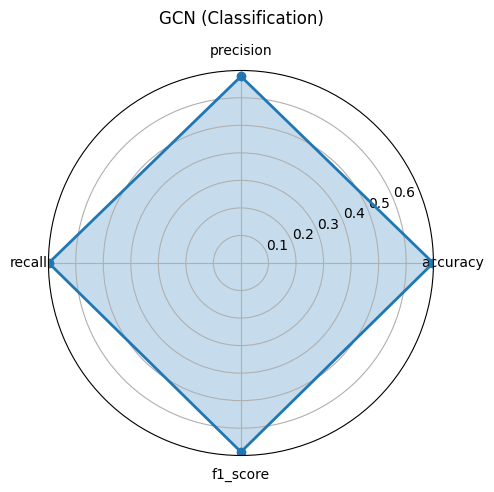

Baseline QSAR regression → model: 'random_forest', input: 'PCA', r2_score: 0.655, mse: 3.150
🔍 GCN regression columns: ['mae', 'mse', 'rmse', 'r2']
Final GCN → r2_score: 0.383, mse: 0.820


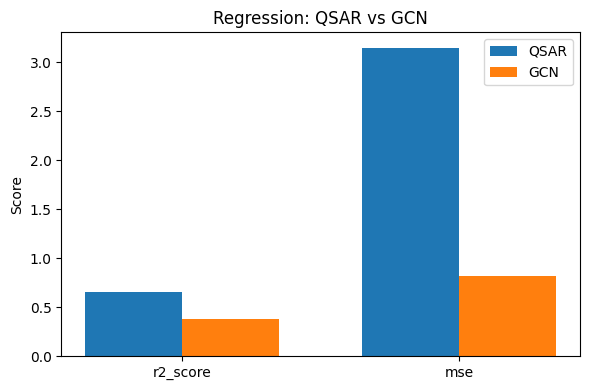

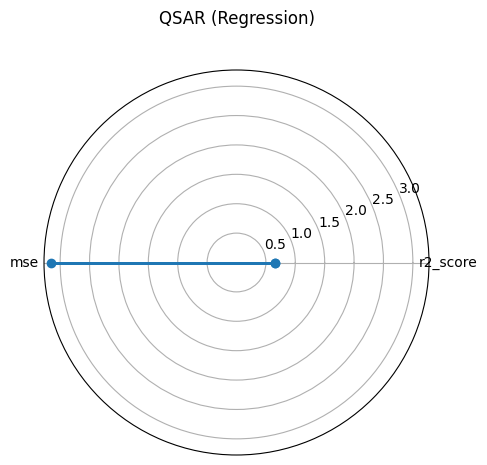

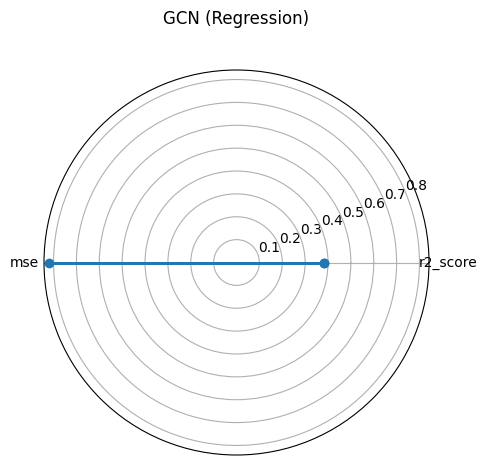

In [21]:
# Imports & Paths
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

root_dir    = "."
bs_dir      = "./6_baseline_comparison"
gcn_results = "./GCN_results"
clf_dir     = "./GCN_results/classification_10fold"
reg_dir     = "./GCN_results/regression_10fold"
results_dir = "./GCN_vs_QSAR_plots"

os.makedirs(results_dir, exist_ok=True)

###Google Colab paths
#root_dir    = "/content/drive/MyDrive/GNN_model_TRPM8_Drug_Potency_prediction/GNN_model_TRPM8_Drug_Potency_prediction-Dolapo"
#bs_dir      = os.path.join(root_dir, "6_baseline_comparison")
#gcn_results = os.path.join(root_dir, "GCN_results")
#clf_dir     = os.path.join(gcn_results, "classification_10fold")
#reg_dir     = os.path.join(gcn_results, "regression_10fold")
#results_dir = os.path.join(root_dir, "GCN_vs_QSAR_plots")
#os.makedirs(results_dir, exist_ok=True)

# ─── plotting helpers ────────────────────────────────────────────────────────

def bar_plot(bvals, gvals, metrics, title, out_path):
    x = np.arange(len(metrics))
    w = 0.35
    fig, ax = plt.subplots(figsize=(6,4))
    ax.bar(x - w/2, bvals, w, label="QSAR")
    ax.bar(x + w/2, gvals, w, label="GCN")
    ax.set_xticks(x);  ax.set_xticklabels(metrics)
    ax.set_ylabel("Score");  ax.set_title(title)
    ax.legend()
    plt.tight_layout()
    fig.savefig(out_path)
    plt.show()           # ← show inline
    plt.close(fig)

def radar_plot(vals, labels, title, out_dir, fn):
    vals = np.array(vals, dtype=float)
    v = np.concatenate([vals, [vals[0]]])
    N = len(labels)
    ang = np.linspace(0, 2*np.pi, N, endpoint=False).tolist()
    ang += ang[:1]

    fig, ax = plt.subplots(figsize=(5,5), subplot_kw=dict(polar=True))
    ax.plot(ang, v, 'o-', lw=2)
    ax.fill(ang, v, alpha=0.25)
    ax.set_xticks(ang[:-1])
    ax.set_xticklabels(labels)
    ax.set_title(title, y=1.1)

    os.makedirs(out_dir, exist_ok=True)
    fig.savefig(os.path.join(out_dir, fn), bbox_inches='tight')
    plt.show()           # ← show inline
    plt.close(fig)


# ─── Classification ─────────────────────────────────────────────────────────

# 1) Best QSAR classifier
qsar_cls = pd.read_csv(os.path.join(bs_dir, "QSAR_classification_performance_summary.csv"))
best_cls = qsar_cls.loc[qsar_cls.accuracy.idxmax()]
print(f"Baseline QSAR classifier → model: '{best_cls.model_type}', "
      f"input: '{best_cls.input_type}', accuracy: {best_cls.accuracy:.3f}")

# 2) Final GCN classifier
gcn_cls = pd.read_csv(os.path.join(clf_dir, "gcn_final_metrics.csv")).iloc[0]
print(f"Final GCN → accuracy: {gcn_cls['accuracy']:.3f}, "
      f"precision: {gcn_cls['precision']:.3f}, "
      f"recall: {gcn_cls['recall']:.3f}, "
      f"f1_score: {gcn_cls['f1_score']:.3f}")

cls_metrics = ['accuracy','precision','recall','f1_score']
df_cls = pd.DataFrame({
    'QSAR': best_cls[cls_metrics].values,
    'GCN':  gcn_cls[cls_metrics].values
}, index=cls_metrics)

bar_plot(df_cls['QSAR'], df_cls['GCN'], cls_metrics,
         "Classification: QSAR vs GCN",
         os.path.join(results_dir, "bar_QSAR_vs_GCN_classification.png"))
radar_plot(df_cls['QSAR'], cls_metrics, "QSAR (Classification)",
           results_dir, "radar_QSAR_classification.png")
radar_plot(df_cls['GCN'],  cls_metrics, "GCN (Classification)",
           results_dir, "radar_GCN_classification.png")

# ─── Regression ───────────────────────────────────────────────────────────────

# 3) Best QSAR regressor
qsar_reg = pd.read_csv(os.path.join(bs_dir, "QSAR_regression_performance_summary.csv"))
best_reg = qsar_reg.loc[qsar_reg.r2_score.idxmax()]
print(f"Baseline QSAR regression → model: '{best_reg.model_type}', "
      f"input: '{best_reg.input_type}', "
      f"r2_score: {best_reg.r2_score:.3f}, mse: {best_reg.mse:.3f}")

# 4) Final GCN regressor & inspect its columns
gcn_reg = pd.read_csv(os.path.join(reg_dir, "gcn_final_metrics_reg.csv")).iloc[0]
print(" GCN regression columns:", list(gcn_reg.index))

#  decide which columns to use:
r2_col  = 'r2_score' if 'r2_score' in gcn_reg.index else ('r2' if 'r2' in gcn_reg.index else None)
mse_col = 'mse'
if r2_col is None:
    raise KeyError("Couldn't find an R² column in your GCN CSV; adjust r2_col manually.")

print(f"Final GCN → r2_score: {gcn_reg[r2_col]:.3f}, mse: {gcn_reg[mse_col]:.3f}")

# 5) build DataFrame and plot
reg_metrics = ['r2_score','mse']
df_reg = pd.DataFrame({
    'QSAR': [ best_reg.r2_score,  best_reg.mse ],
    'GCN':  [ gcn_reg[r2_col],   gcn_reg[mse_col] ]
}, index=reg_metrics)

bar_plot(df_reg['QSAR'], df_reg['GCN'], reg_metrics,
         "Regression: QSAR vs GCN",
         os.path.join(results_dir, "bar_QSAR_vs_GCN_regression.png"))
radar_plot(df_reg['QSAR'], reg_metrics, "QSAR (Regression)",
           results_dir, "radar_QSAR_regression.png")
radar_plot(df_reg['GCN'],  reg_metrics, "GCN (Regression)",
           results_dir, "radar_GCN_regression.png")

#print("All plots written to", results_dir)
